In [202]:
import json
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cfit.fitness.HLAweights import HLAweights
from cfit.fitness.ImmuneCloneFitness import ImmuneCloneFitness
from cfit.fitness.VariableImmuneCloneFitness import VariableImmuneCloneFitness
from cfit.fitness.DGCloneFitness import DGCloneFitness
from cfit.fitness.neo_quality.ARNeoantigenQuality import ARNeoantigenQuality
from cfit.plot.PlotTreeAll import PlotTreeAll
from cfit.tree.mutation.Neoantigen import Neoantigen
from cfit.util.Analysis import Analysis
from cfit.util.Analysis import AnalysisArgs
from cfit.util.Log import Log
from cfit.util.Utils import Utils
from scipy.stats import pearsonr, linregress

import scipy
import seaborn as sns


In [47]:
hdir='Data_orig'

In [164]:
args = AnalysisArgs()
args.netMHC = "3.4"
args.kd_thr = 500 # threshold on neoantigen Kd
args.dir = hdir
odir = os.path.join(args.dir, "ntau_AR_"+args.netMHC)
if not os.path.exists(odir):
    os.mkdir(odir)


In [205]:
a = 26.
k = 1.
Neoantigen.WEPS = 0.0
tau = 0.04
npos = "1-9"

modelParamValues = [a, k, tau]
modelParamNames = ["a", "k", "tau"]
params = pd.DataFrame([modelParamValues])
params.columns = modelParamNames
#params.to_csv(os.path.join(odir, "parameters_"+suffix+".txt"), sep="\t", index=False)
params

,a,k,tau
0,26.0,1.0,0.04


In [50]:
anl = Analysis()
anl.set_MHC_version(args.netMHC)
mappingfile = os.path.join(args.dir, "mapping.json")
with open(mappingfile) as f:
    mappingjs = json.load(f)
configfile = os.path.join(args.dir, "config.json")
with open(configfile) as f:
    configjs = json.load(f)    
vcfdir = os.path.join(args.dir, configjs["vcf_dir"])
alndir = os.path.join(args.dir, configjs["aln_dir"])
iedbfasta = os.path.join(alndir, "enemy.fasta")

anl.clonal = 1  # whether to take the trees into account in the analysis, 1 - yes
anl.ntrees = args.ntrees  # number of top scoring trees

anl.initialize_config(configjs, mappingjs, args=args)    

In [51]:
HLAW = HLAweights('1-9')

In [267]:
Qmodel = ARNeoantigenQuality(alndir=alndir, iedbfasta=iedbfasta)  
anl.set_neantigen_quality_model(Qmodel)
anl.compute_neoantigen_sample_qualities(a=a, k=k, HLAW=HLAW, include_A=True, include_R=True,
                                            kdthr=args.kd_thr, KDnormalize=1.)

In [270]:
# set fitness components


#Utils.AGGR = "MAX"  # needed only for output, used in Utils.writeline


#anl.set_fitness_model_component(quantityFitnessModelComp, "immune", 1.)

#fitnessModelComp2 = DGCloneFitness(genes=["TP53","KRAS","CDKN2A", "SMAD4"])

#anl.set_fitness_model_component(fitnessModelComp2, "dg", 0.0)

# perform evolutionary predictions:
# 1. compute neoantigen qualities
qualityFitnessModelComp = ImmuneCloneFitness(aggrfun=max)
anl.set_fitness_model_component(qualityFitnessModelComp, "immune", 1.)


quantityFitnessModelComp = VariableImmuneCloneFitness(quality_function=lambda neo, sampleTree, sample: 1, 
                                                      aggrfun=sum)
anl.set_fitness_model_component(quantityFitnessModelComp, "immune", 1.)


# 2. compute fitness of all clones
anl.compute_node_fitness(recompute_components=True)

In [9]:
#anl.write_neoantigen_fitness(os.path.join(odir, "Neontigen_qualities"), exclusive=True, longitudinal=False,
#                                 clonal=True)


In [264]:
pv = [anl.classify_survival(beta=1., tau=tau, outdir=None, OS=True, PFS=True, quantile=quantile)['pval_OS']
 for tau in np.linspace(0,5,200)]

In [258]:
pv

[0.026552867024857464,
 0.001974644650803211,
 0.025978228594309,
 0.08984725321524496,
 0.08869475631249611,
 0.08869475631249611,
 0.1435247009207279,
 0.1435247009207279,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.15824626943901277,
 0.11637515649922593,
 0.11637515649922593,
 0.11637515649922593,
 0.11637515649922593,
 0.11637515649922593,
 0.11637515649922593,
 0.11637515649922593,
 0.11637515649922593,
 0.09797313559228105,
 0.09797313559228105,
 0.09797313559228105,
 0.09797313559228105,
 0.09797313559228105,
 0.09797313559228105,
 0.09797313559228105,
 0.09797313559228105,
 0.09797313559228105,
 0.10188272722290516,
 0.10188272722290516,
 0.10188272722290516,
 0.10188272722290516,
 0.10188272722290516,
 0.10188272722290516,
 0.101882727

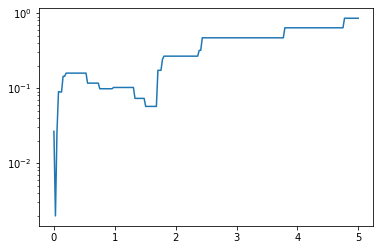

In [259]:
plt.plot(np.linspace(0,5,200),pv)
plt.yscale("log")

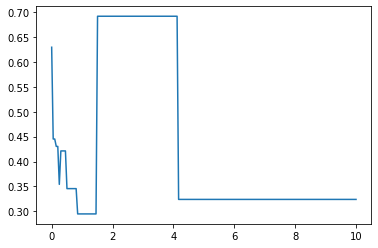

In [253]:
plt.plot(np.linspace(0,5,200),pv)

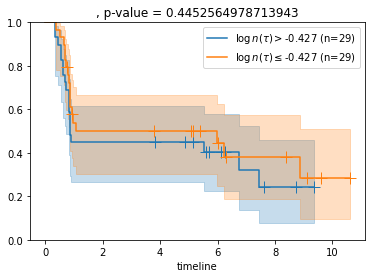

In [271]:
# Survival analysis
pof_surv = open(os.path.join(odir, "pvalues_survival.txt"), 'w')
Utils.writelineHeader(pof_surv, modelParamNames=modelParamNames)

quantile = 0.5
res_surv = anl.classify_survival(beta=1., tau=tau, outdir=None, OS=True, PFS=True, quantile=quantile)
modelParamValues = [a, k, tau, quantile]
Utils.writeline(anl, "AR", res_surv, modelParamValues, Neoantigen.WEPS,
                        "AR", pof=pof_surv)
pof_surv.close()
anl.plot_survival(os.path.join(odir, "survival_plot_OS_q_"+str(quantile)+".pdf"), 
                  OS=True, pval=res_surv["pval_OS"], quantile=quantile, show=True)


In [117]:
res_surv

{'score_OS': 2.2122812786467168,
 'pval_OS': 0.13691607209100665,
 'score_PFS': 1.1515151515151518,
 'pval_PFS': 0.2832321998580136,
 'AUC': ([0], [0]),
 'n1': 29,
 'n2': 29}

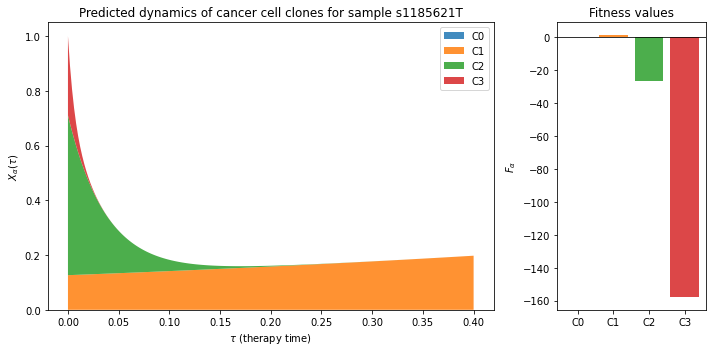

In [219]:
sample_statistics = anl.sample_statistics(kd_thr=args.kd_thr)
fitness_statistics = anl.fitness_sample_statistics()
#sample_statistics.to_csv(os.path.join(odir, "sample_statistics.txt"), sep="\t", index=False)
#fitness_statistics.to_csv(os.path.join(odir, "fitness_sample_statistics.txt"), sep="\t", index=False)

ntaus = [np.exp(pat.q) for pat in anl.patients.values()]
#ntaus.sort()
#plt.hist(ntaus,bins=np.arange(0,1.01,0.05))
#plt.xlabel(r'$n(\tau)$')
#plt.show()
#plt.savefig(os.path.join(odir, "ntau_hist.pdf"))
#plt.close()

#outdir_trees = os.path.join(odir, 'Tree_plots')
#if not os.path.exists(outdir_trees):
#    os.mkdir(outdir_trees)

for patname in anl.patients:
    patient = anl.patients[patname]
    plottree = PlotTreeAll(patient, drivers=["TP53","KRAS"], tid=0, save_html=False, show=True)
    df=pd.DataFrame([["C"+str(node.id), node.Y,node.fitness] for node in anl.samples[patname].trees[0].nodes.values()],columns=["Clone","X0","F"])
    plot_response(df, 0.4, patname)    
    break

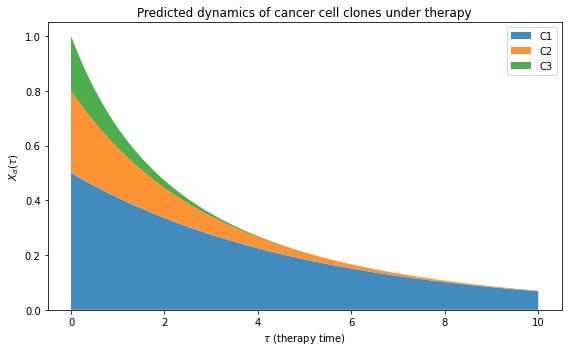

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample input table: clone ID, initial frequency, fitness
data = {
    'Clone': ['C1', 'C2', 'C3'],
    'X0': [0.5, 0.3, 0.2],
    'F': [-0.2, -0.5, -1.0]  # Fitness values
}
df = pd.DataFrame(data)

# Define time points
tau = np.linspace(0, 10, 200)

# Compute X_alpha(tau) for each clone
X = []
for idx, row in df.iterrows():
    X_alpha_tau = row['X0'] * np.exp(row['F'] * tau)
    X.append(X_alpha_tau)

X = np.array(X)

# Plot stacked area chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.stackplot(tau, X, labels=df['Clone'], alpha=0.85)
ax.set_xlabel(r'$\tau$ (therapy time)')
ax.set_ylabel(r'$X_\alpha(\tau)$')
ax.set_title('Predicted dynamics of cancer cell clones under therapy')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()



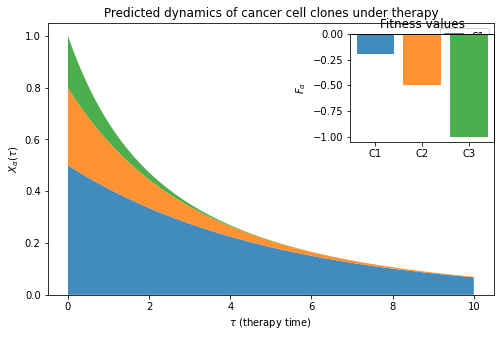

In [23]:
# Plot both: stacked plot + fitness bar chart as inset

fig, ax = plt.subplots(figsize=(8, 5))

# Main stacked area plot
stack = ax.stackplot(tau, X, labels=df['Clone'], alpha=0.85)
ax.set_xlabel(r'$\tau$ (therapy time)')
ax.set_ylabel(r'$X_\alpha(\tau)$')
ax.set_title('Predicted dynamics of cancer cell clones under therapy')
ax.legend(loc='upper right')

# Add fitness bar plot as inset
inset_ax = fig.add_axes([0.65, 0.55, 0.25, 0.3])  # [left, bottom, width, height]
bars = inset_ax.bar(df['Clone'], df['F'], color=[s.get_facecolor() for s in stack])
inset_ax.axhline(0, color='black', linewidth=0.8)
inset_ax.set_title('Fitness values')
inset_ax.set_ylabel(r'$F_\alpha$')
inset_ax.set_xticks(range(len(df['Clone'])))
inset_ax.set_xticklabels(df['Clone'])

#plt.tight_layout()
plt.show()


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_response(df, max_tau, sample):
    # Define time points
    tau = np.linspace(0, max_tau, 200)

    # Compute X_alpha(tau) for each clone
    X = []
    for idx, row in df.iterrows():
        X_alpha_tau = row['X0'] * np.exp(row['F'] * tau)
        X.append(X_alpha_tau)

    X = np.array(X)

    # Create figure with two subplots: dynamics and fitness
    fig, (ax_main, ax_bar) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})

    # Main stacked area plot
    stack = ax_main.stackplot(tau, X, labels=df['Clone'], alpha=0.85)
    ax_main.set_xlabel(r'$\tau$ (therapy time)')
    ax_main.set_ylabel(r'$X_\alpha(\tau)$')
    ax_main.set_title('Predicted dynamics of cancer cell clones for sample '+sample)
    ax_main.legend(loc='upper right')

    # Fitness bar plot
    bars = ax_bar.bar(df['Clone'], df['F'], color=[s.get_facecolor() for s in stack])
    ax_bar.axhline(0, color='black', linewidth=0.8)
    ax_bar.set_title('Fitness values')
    ax_bar.set_ylabel(r'$F_\alpha$')
    ax_bar.set_xticks(range(len(df['Clone'])))
    ax_bar.set_xticklabels(df['Clone'])

    plt.tight_layout()
    plt.show()



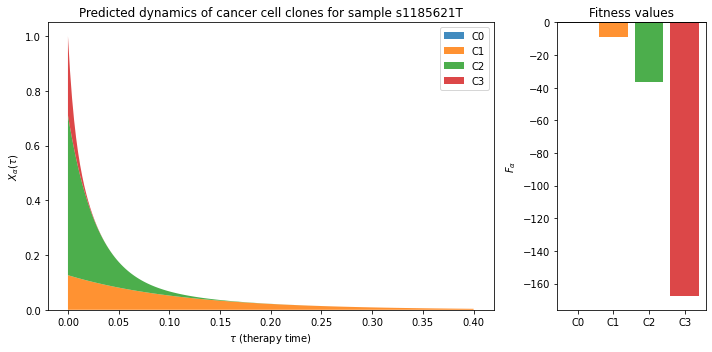

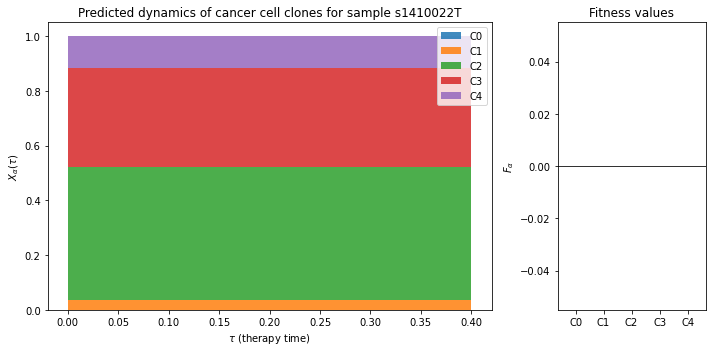

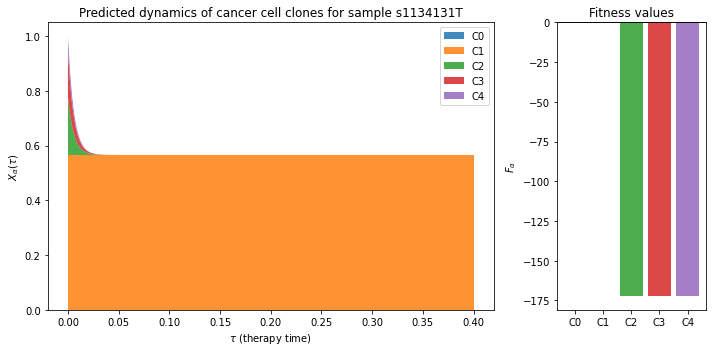

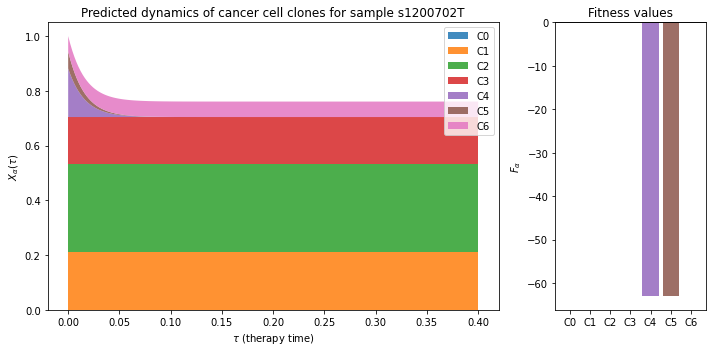

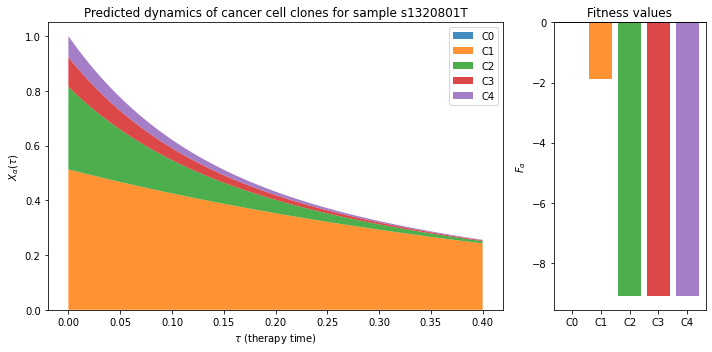

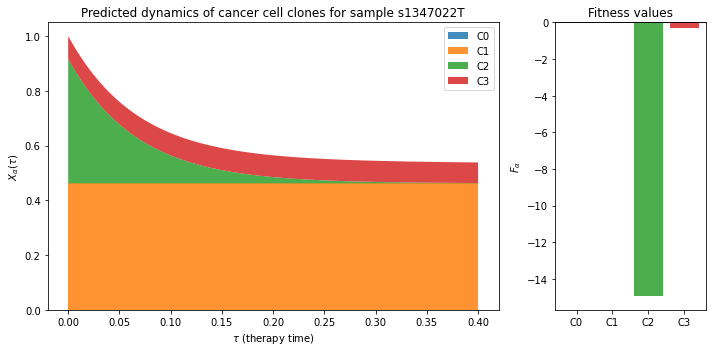

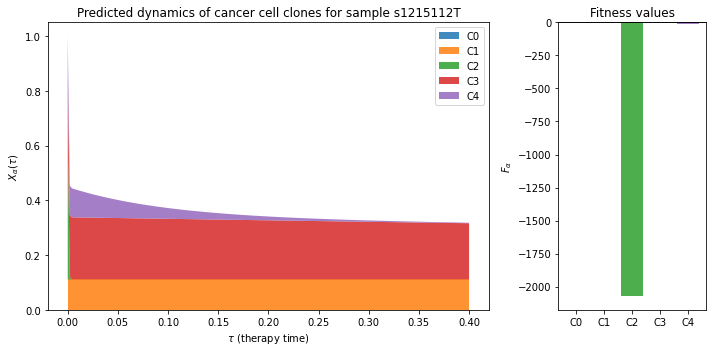

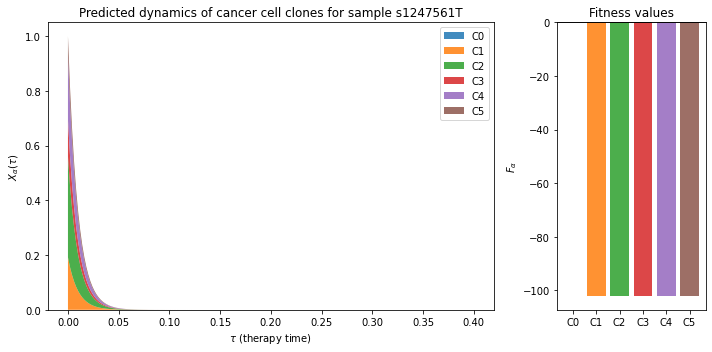

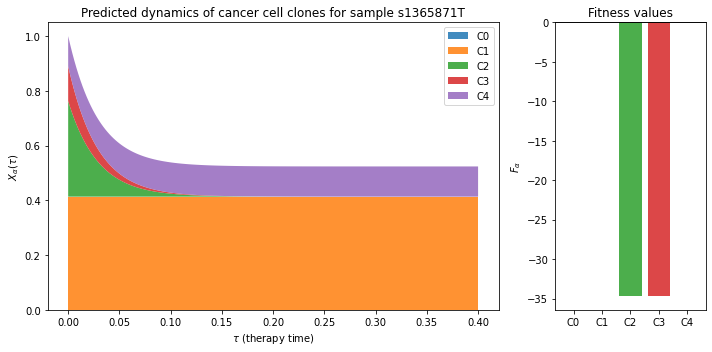

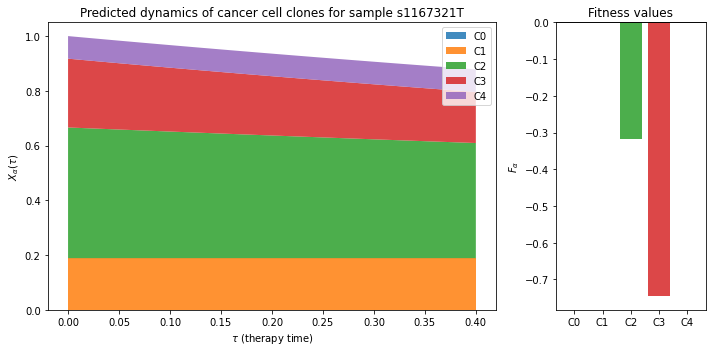

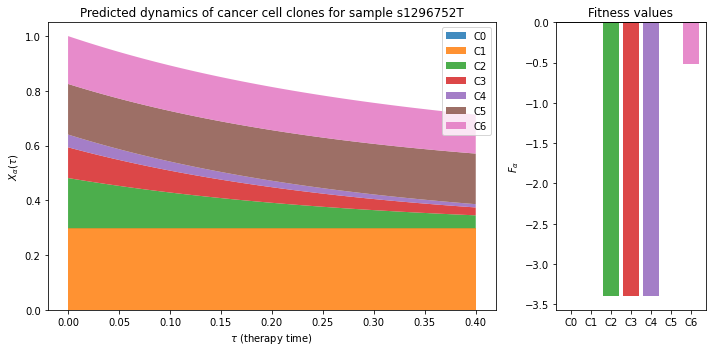

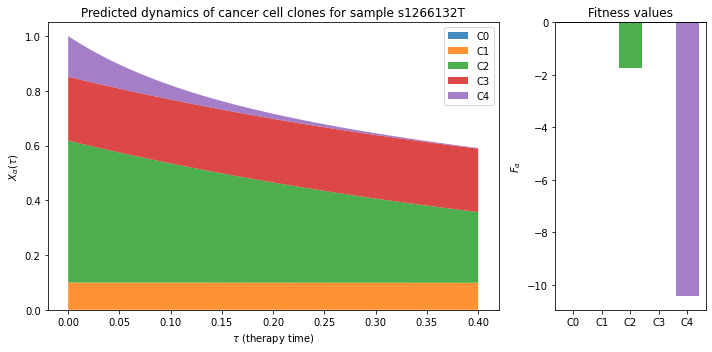

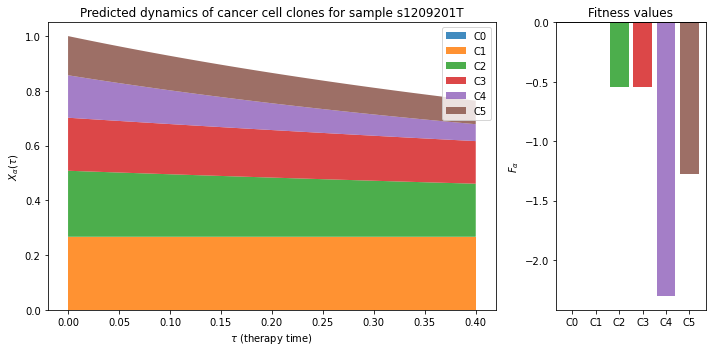

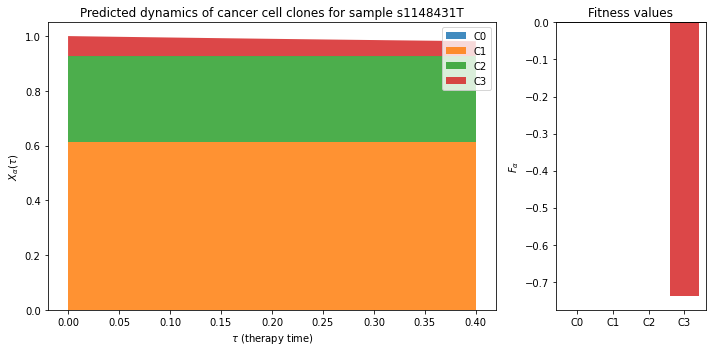

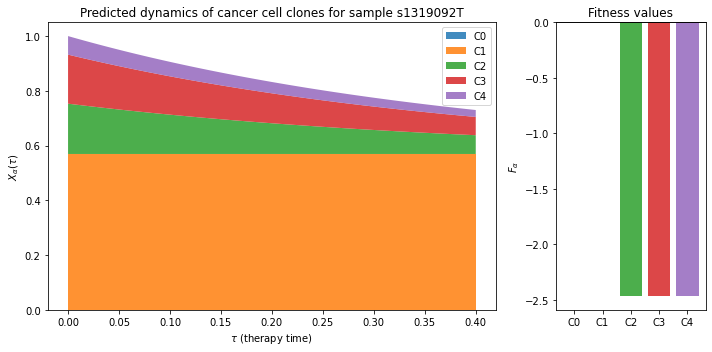

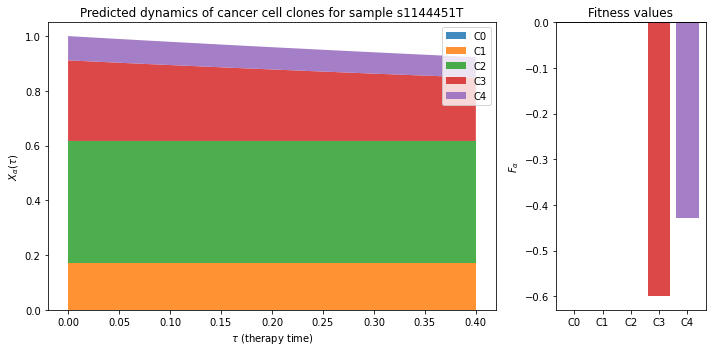

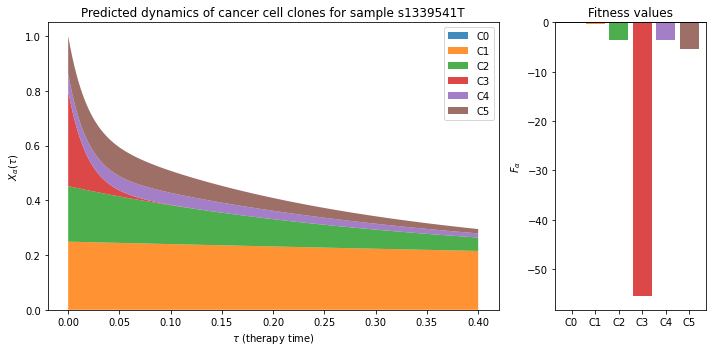

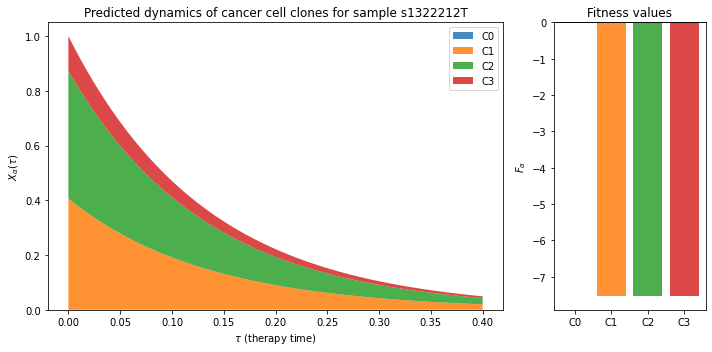

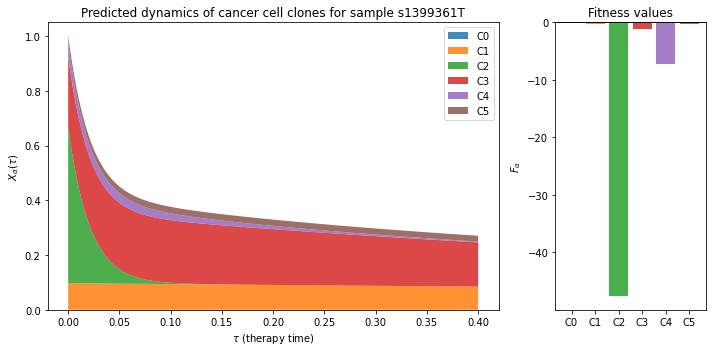

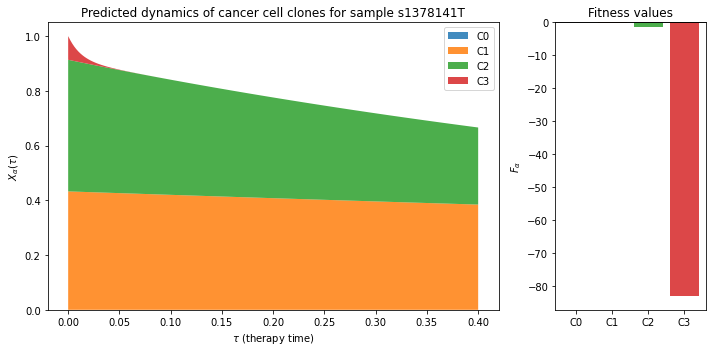

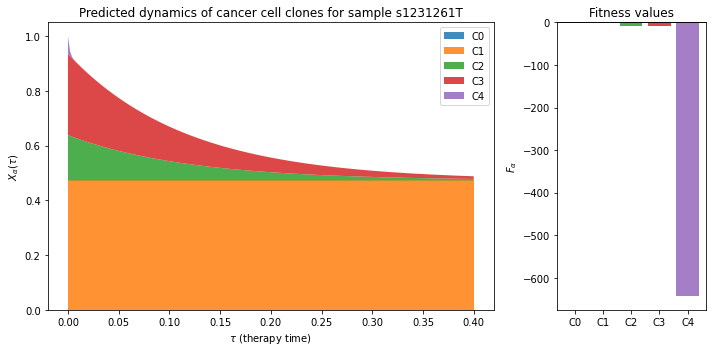

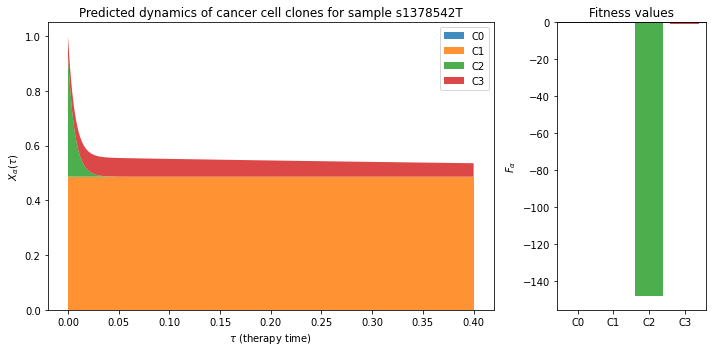

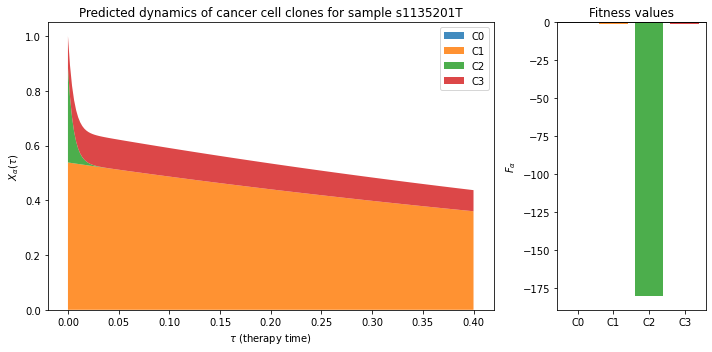

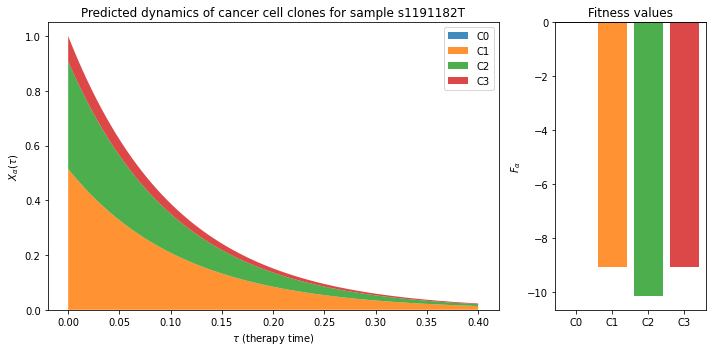

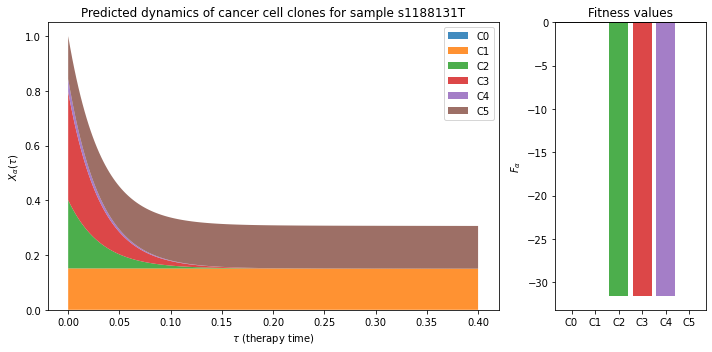

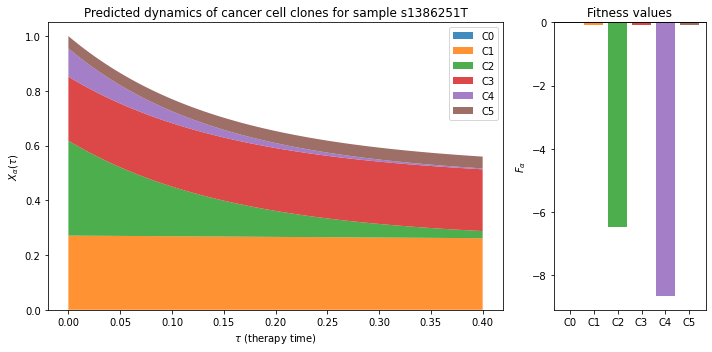

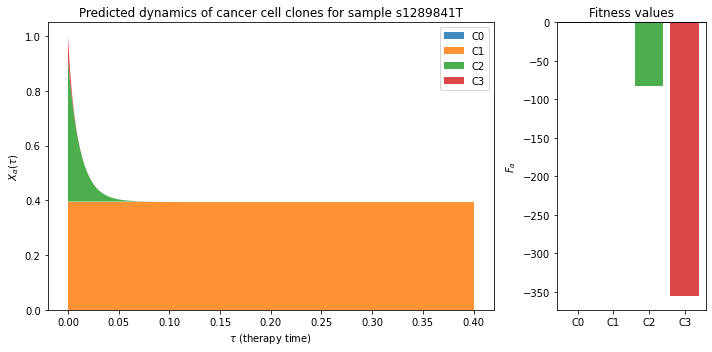

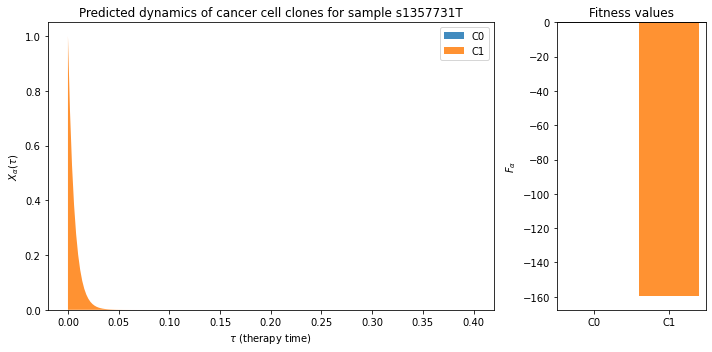

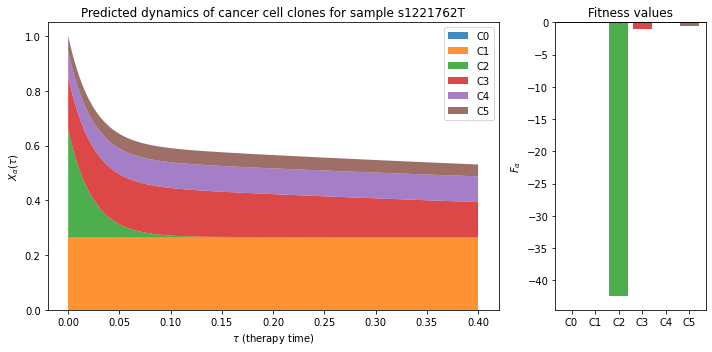

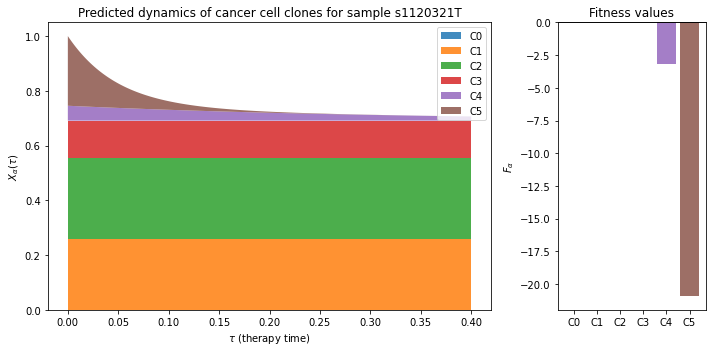

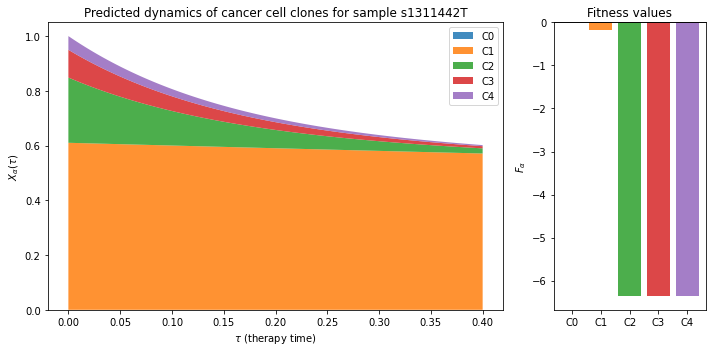

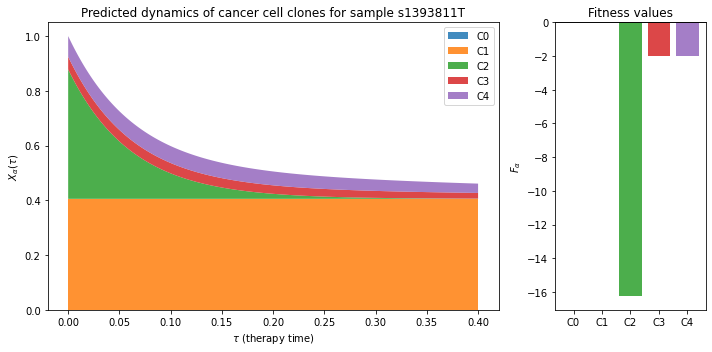

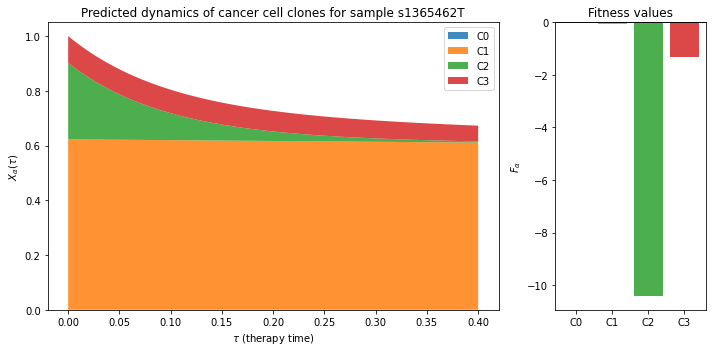

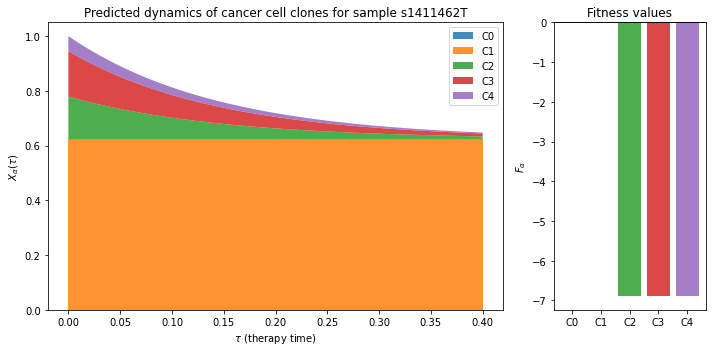

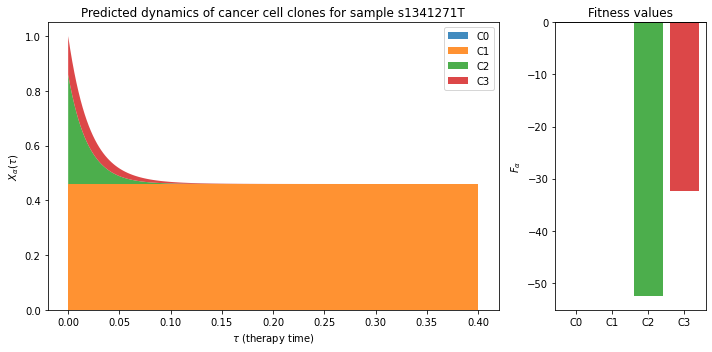

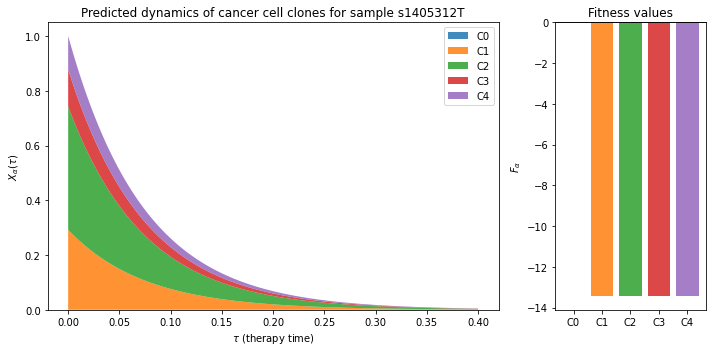

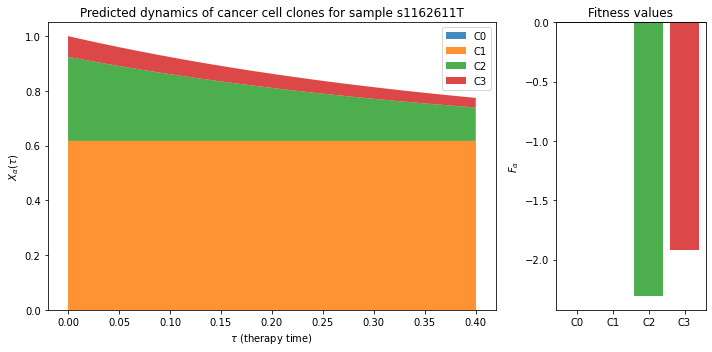

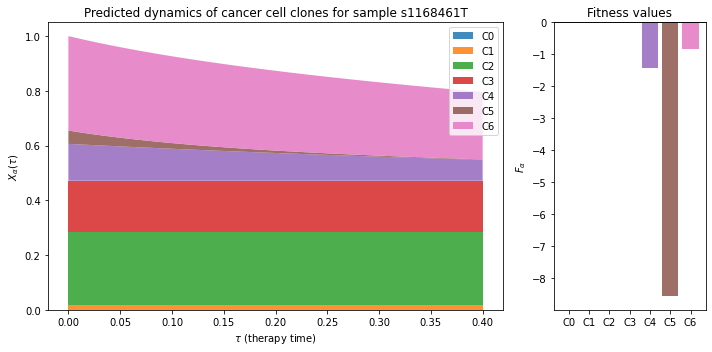

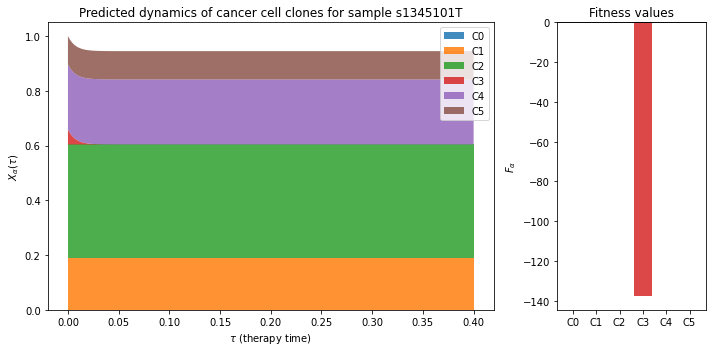

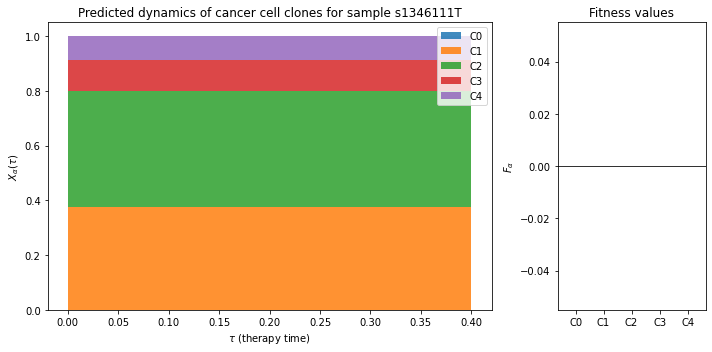

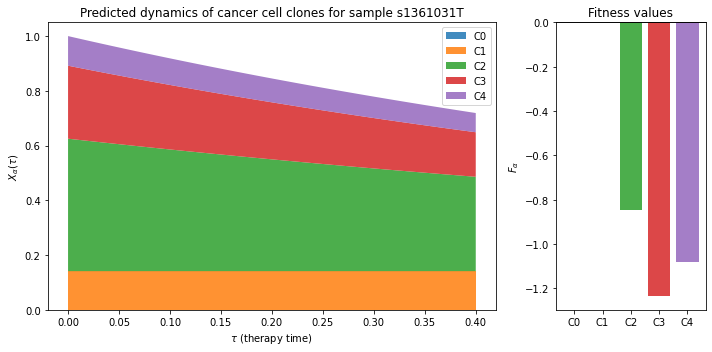

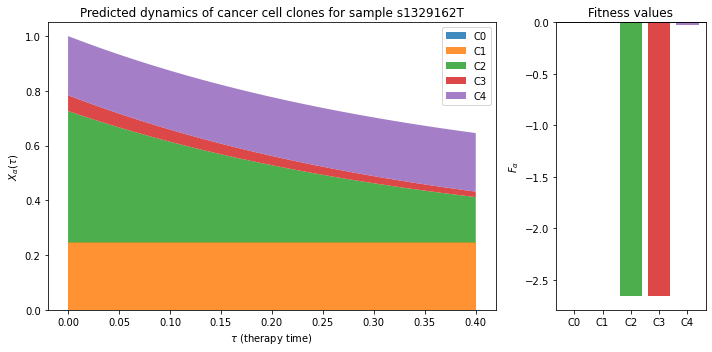

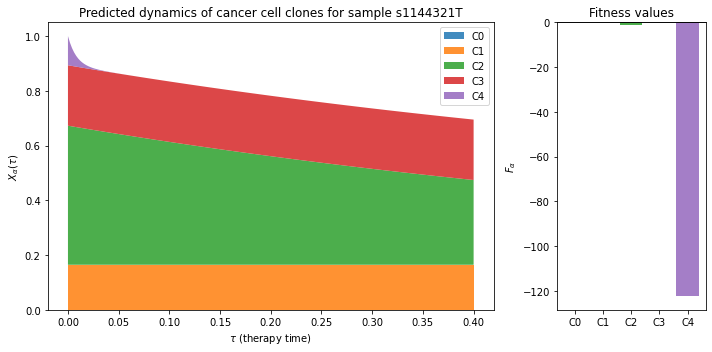

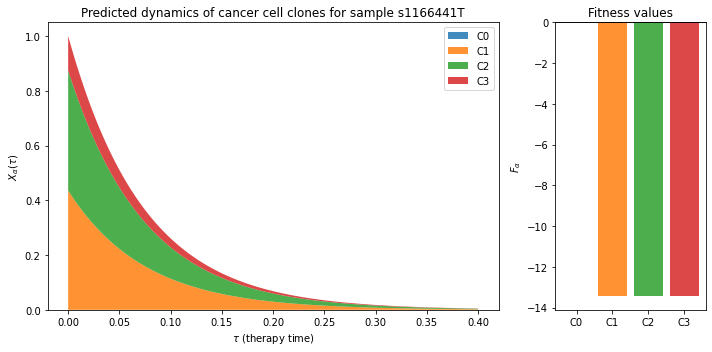

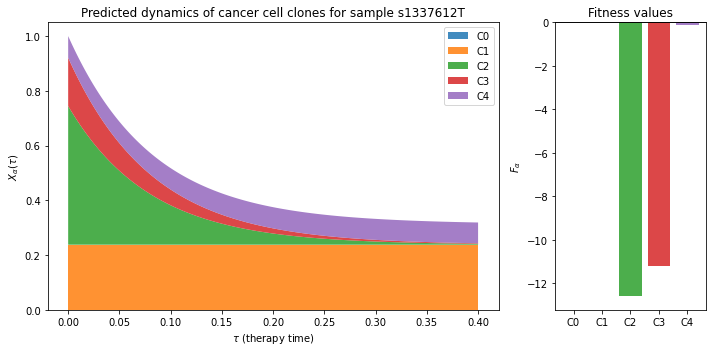

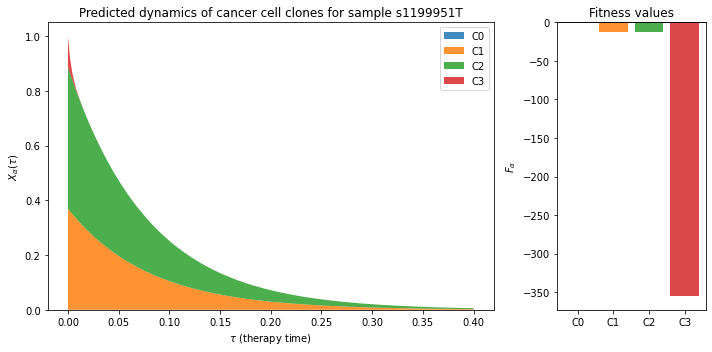

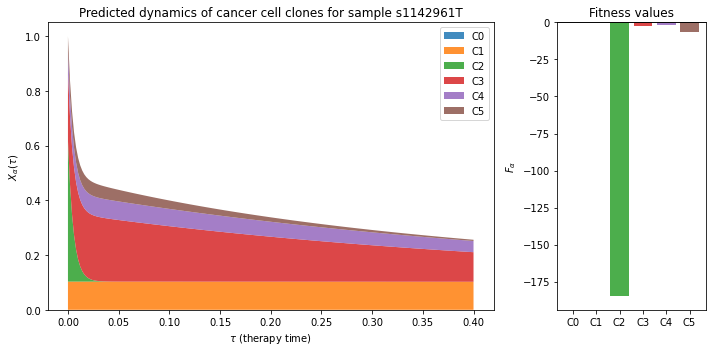

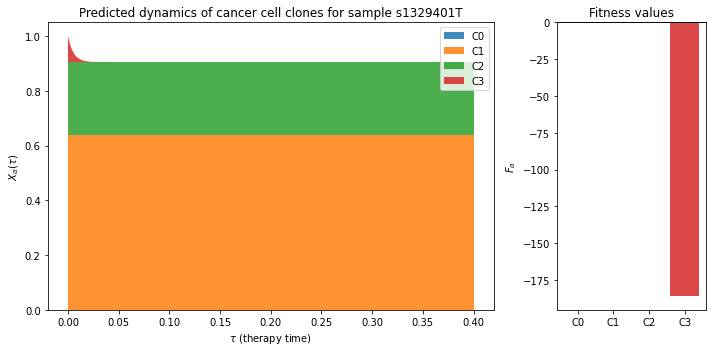

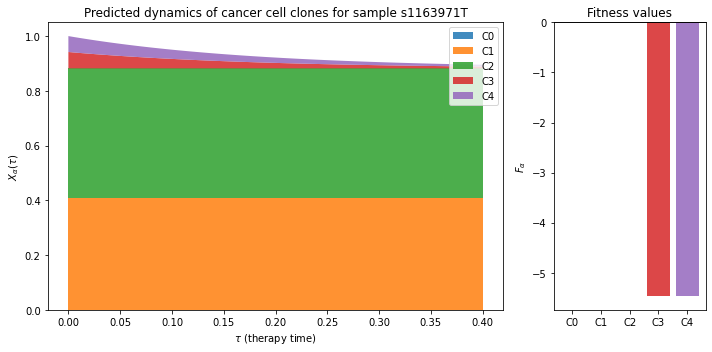

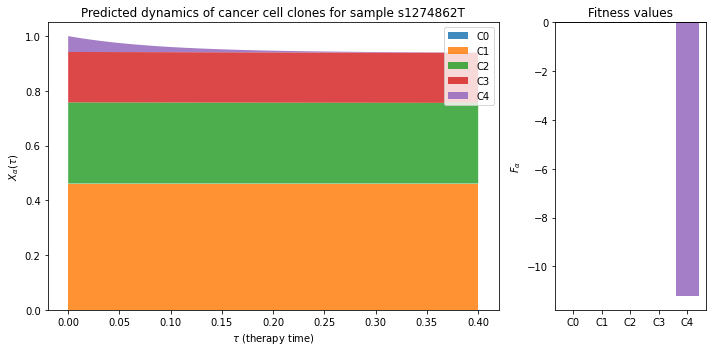

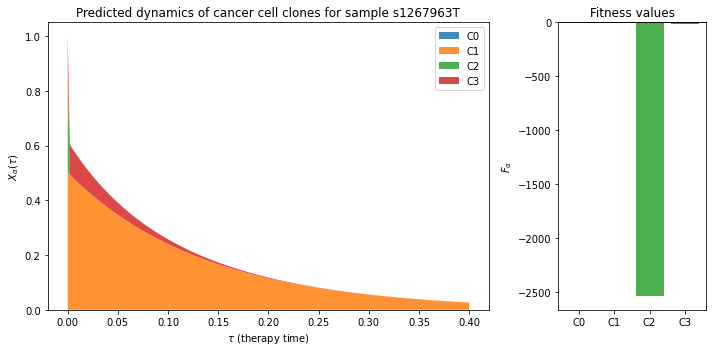

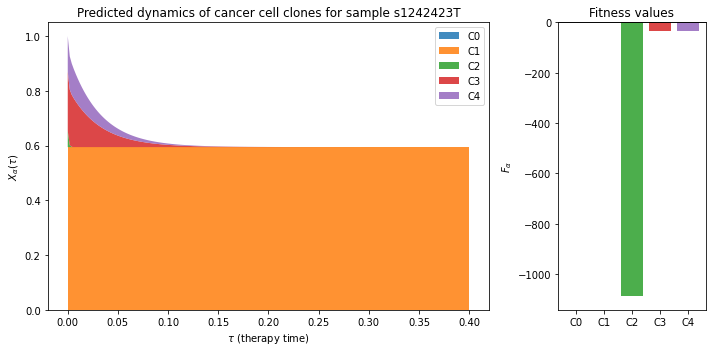

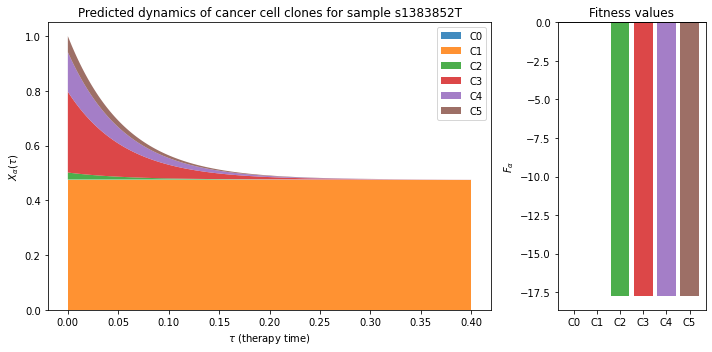

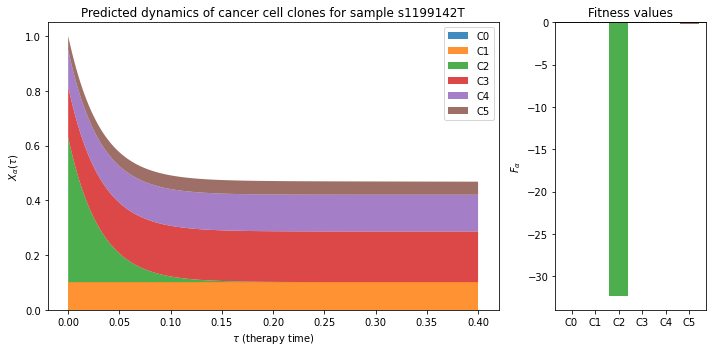

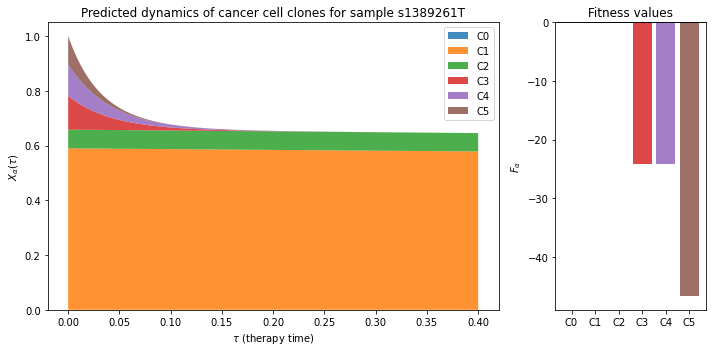

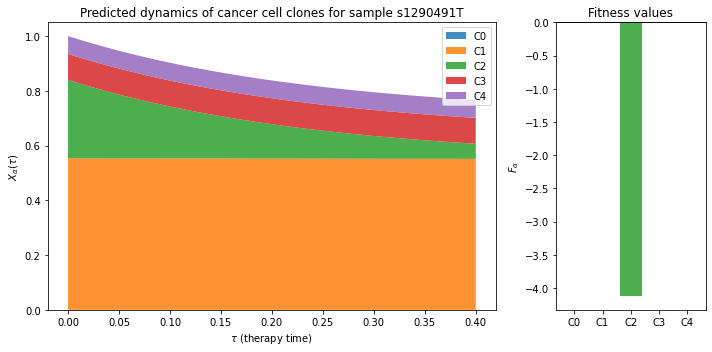

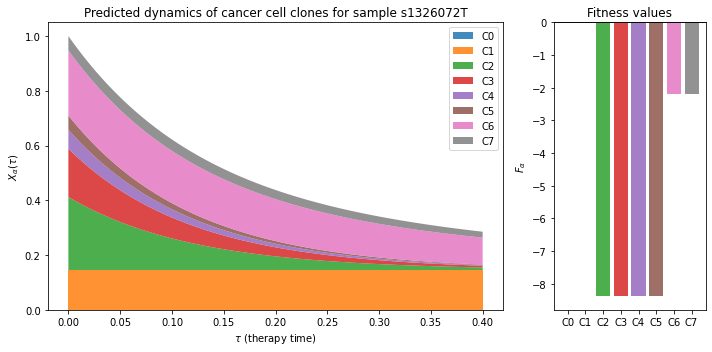

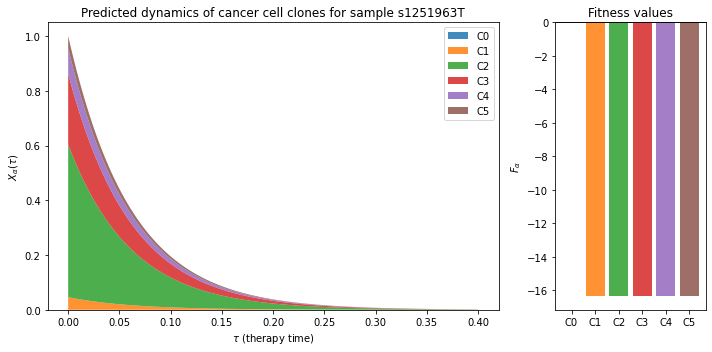

In [56]:
for sample in anl.samples:
    df=pd.DataFrame([["C"+str(node.id), node.Y,node.fitness] for node in anl.samples[sample].trees[0].nodes.values()],columns=["Clone","X0","F"])
    plot_response(df, 0.4, sample)

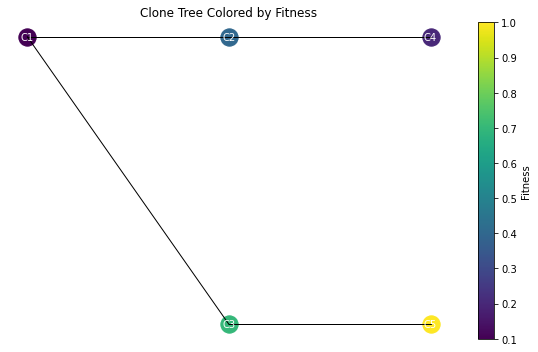

In [57]:
# Let's assume CloneNode and CloneTree are already defined in the uploaded files.
# We'll simulate a simple tree and plot it, coloring nodes by their fitness.

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Dummy class definitions to illustrate plotting logic (replace with actual imports in use)
class CloneNode:
    def __init__(self, name, fitness, children=None):
        self.name = name
        self.fitness = fitness
        self.children = children if children else []

class CloneTree:
    def __init__(self, root):
        self.root = root

# Example tree structure
node4 = CloneNode("C4", fitness=0.2)
node5 = CloneNode("C5", fitness=1.0)
node2 = CloneNode("C2", fitness=0.4, children=[node4])
node3 = CloneNode("C3", fitness=0.7, children=[node5])
root = CloneNode("C1", fitness=0.1, children=[node2, node3])
tree = CloneTree(root=root)

# Flatten tree to get all nodes with depth info
def flatten_tree(node, depth=0, pos=0, positions=None, nodes=None):
    if positions is None: positions = {}
    if nodes is None: nodes = []
    positions[node] = (depth, pos)
    nodes.append(node)
    for i, child in enumerate(node.children):
        flatten_tree(child, depth + 1, pos + i, positions, nodes)
    return positions, nodes

positions, all_nodes = flatten_tree(tree.root)

# Normalize fitness values for colormap
fitness_values = [node.fitness for node in all_nodes]
norm = mcolors.Normalize(vmin=min(fitness_values), vmax=max(fitness_values))
cmap = cm.get_cmap('viridis')

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
for node in all_nodes:
    x, y = positions[node]
    ax.scatter(x, -y, s=300, color=cmap(norm(node.fitness)))
    ax.text(x, -y, node.name, ha='center', va='center', fontsize=10, color='white')
    for child in node.children:
        x_child, y_child = positions[child]
        ax.plot([x, x_child], [-y, -y_child], color='black', linewidth=1)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Fitness')

ax.set_title("Clone Tree Colored by Fitness")
ax.axis('off')
plt.tight_layout()



In [35]:
[neo.quality for neo in anl.patients['s1185621T'].timePoints['TP1'].trees()[0].nodes[3].neoantigens]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [145]:
patnames = list(anl.patients.keys())

In [154]:
trees = [anl.patients[patname].timePoints['TP1'].trees()[0] for patname in patnames]

In [174]:
[(node.Y, len([neo.kD for neo in node.neoantigens])) for node in trees[5].nodes.values()]

In [181]:
[(node.Y, len([neo.kD for neo in node.neoantigens])) for node in trees[5].nodes.values()]

[(0.0, 0),
 (0.4620183668341178, 0),
 (0.45395727356616006, 9),
 (0.08402435959972211, 8)]

In [184]:
clonal = [(tree.nodes[1].Y, len(tree.nodes[1].neoantigens)) for tree in trees]

In [190]:
len([x for x in clonal if x[1]==0] )/58

0.3620689655172414

In [209]:
data = pd.DataFrame(zip([anl.patients[patname].OS for patname in patnames],[anl.patients[patname].q for patname in patnames]), columns=["OS","ntau"])
data["Cohort"] = ["STS" if os<=2 else "LTS" for os in data.OS]

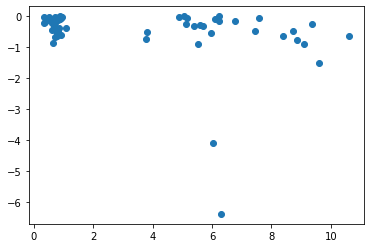

In [210]:
plt.scatter([anl.patients[patname].OS for patname in patnames],[anl.patients[patname].q for patname in patnames])


In [ ]:

cols = ["Immune_fitness_cost1", "Immune_fitness_cost2", "New_clones_immune_fitness_cost",
            "Private_volume", "IG"]

    for col in cols:
        ax = sns.swarmplot(x='Cohort', y=col, data=tumor_stats, dodge=True)
        sns.boxplot(x='Cohort', y=col, data=tumor_stats,
                    boxprops={'facecolor': 'None'})
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:2], labels[:2], frameon=False)
        x1 = tumor_stats[tumor_stats.Cohort == 'STS'][col]
        x2 = tumor_stats[tumor_stats.Cohort != 'STS'][col]
        try:
            pval = scipy.stats.mannwhitneyu(x1, x2, alternative='two-sided').pvalue
        except:
            pval = 0.0
        ax.set_title("pvalue=" + str(pval))
        plt.savefig(os.path.join(odir1, col + ".pdf"))
        plt.close()


Text(28.25, 0.5, '$n(\\tau)$')

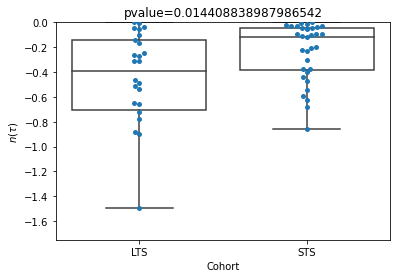

In [214]:
ax = sns.swarmplot(x='Cohort', y='ntau', data=data, dodge=True)
sns.boxplot(x='Cohort', y='ntau', data=data,
                    boxprops={'facecolor': 'None'})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], frameon=False)
x1 = data[data.Cohort == 'STS']['ntau']
x2 = data[data.Cohort != 'STS']['ntau']
try:
    pval = scipy.stats.mannwhitneyu(x1, x2, alternative='two-sided').pvalue
except:
    pval = 0.0
ax.set_title("pvalue=" + str(pval))
ax.set_ylim(-1.75,0)
ax.set_ylabel(r'$n(\tau)$')
#plt.savefig(os.path.join(odir1, col + ".pdf"))
#        plt.close()
